In [2]:
# example_meta_data_reader.ipynb
# Authors: Stephan Meighen-Berger
# Shows how to deal with the output files

In [3]:

import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib widget
# %matplotlib qt

In [6]:
# Example loading a directory (highly recommend using lazy loading)
example_set = ak.from_parquet('/home/unimelb.edu.au/smeighenberg/data/orca_1/job_1/custom_1002_meta_data.parquet')

In [7]:
# Example loading a single file
# example_set = ak.from_parquet('./output/custom_1337_meta_data.parquet')

In [8]:
# The events are split into three parts:
#   - lepton: the light from the generated lepton
#   - hadron: the light produced from the associated hadronic cascade (at production point)
#   - total: the light from both parts
# Each of these fields is formatted the same way
example_set.fields

['event_id', 'mc_truth', 'primary_lepton_1', 'primary_hadron_1', 'total']

In [10]:
example_set.total.fields

['sensor_id',
 'sensor_pos_x',
 'sensor_pos_y',
 'sensor_pos_z',
 'sensor_string_id',
 't']

In [11]:
# Example for one event
event_id = 0
# The sensors hit
print("Total number of hits:")
print(len(example_set.total.sensor_id[event_id]))
print('The hit sensors: ')
print(example_set.total.sensor_id[event_id])
print('Their associated strings')
print(example_set.total.sensor_string_id[event_id])
print('The hit times')
print(example_set.total.t[event_id])

Total number of hits:
230
The hit sensors: 
[76, 208, 248, 383, 384, 670, 673, ..., 3198, 3198, 3199, 3199, 3200, 3203]
Their associated strings
[3, 9, 11, 17, 17, 30, 30, 32, 35, ..., 145, 145, 145, 145, 145, 145, 145, 145]
The hit times
[703, 574, 540, 825, 483, 421, 525, 501, ..., 138, 149, 147, 202, 168, 194, 300]


In [22]:
def parquet_sub_plotting(
        data, e_id, det,
        channel='total',
        show_lepton=True,
        scaling=20,
        number_of_hits=1000,
        hitcut=3
    ):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hit_counts = []
    subset_ids = np.random.randint(
        0,
        len(data[channel].sensor_pos_x[e_id])-1,
        size=number_of_hits
    )
    print('Total amount of hits: %d' %len(data[channel].sensor_pos_x[e_id]))
    print('Using a subset of %d for plotting' %number_of_hits)
    event_id = e_id
    sensor_comb = np.array([
        [data[channel].sensor_pos_x[event_id][subset_ids][i],
        data[channel].sensor_pos_y[event_id][subset_ids][i],
        data[channel].sensor_pos_z[event_id][subset_ids][i]
        ]
        for i in range(number_of_hits)
    ])
    print('Fetching unique modules and their hits')
    hit_doms, hit_counts = np.unique(sensor_comb, axis=0, return_counts=True)
    print('Number of hit doms: %d' %len(hit_doms))
    hit_counts = np.log10(hit_counts)
    hit_counts[hit_counts < np.log10(hitcut)] = 0.
    print('Finished the modules')
    print('Plotting...')
    ax.scatter(
        hit_doms[:, 0],
        hit_doms[:, 1],
        hit_doms[:, 2],
        s=(
            hit_counts * scaling
        ),
        color='r', alpha=0.5)
    print('Finished modules')
    if show_lepton:
        print('Plotting lepton...')
        ax.scatter(
            data.primary_lepton_1.loss_pos_x[event_id],
            data.primary_lepton_1.loss_pos_y[event_id],
            data.primary_lepton_1.loss_pos_z[event_id],
            s=( scaling
            ),
            color='blue', alpha=0.5)
        print('Finished lepton')
    ax.scatter(
        det[:, 0],
        det[:, 1],
        det[:, 2],
        s=1,
        color='k', alpha=0.5)
    ax.set_xlim(min(det[:, 0]), max(det[:, 0]))
    ax.set_ylim(min(det[:, 1]), max(det[:, 1]))
    ax.set_zlim(min(det[:, 2]), max(det[:, 2]))
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    plt.title(
        'Event %d with pdg id = %d and energy %.1f GeV' % (
            event_id,
            data.mc_truth.injection_type[event_id],
            data.mc_truth.injection_energy[event_id]
            )
    )
    plt.show()

In [23]:
# Getting the detector
pos = []
with open('../prometheus/data/orca-geo') as geo_in:
    read_lines = geo_in.readlines()
    modules_i = read_lines.index("### Modules ###\n")   
    for line in read_lines[modules_i+1:]:
        line = line.strip("\n").split("\t")
        pos.append(
            np.array([float(line[0]), float(line[1]),
            float(line[2])]))
    det = np.array(pos)
det = det - np.mean(det, axis=0)

Total amount of hits: 976
Using a subset of 1000 for plotting
Fetching unique modules and their hits
Number of hit doms: 65
Finished the modules
Plotting...
Finished modules
Plotting lepton...
Finished lepton


/tmp/ipykernel_15585/3809075380.py:31: RuntimeWarning: divide by zero encountered in log10
  hit_counts[hit_counts < np.log10(hitcut)] = 0.


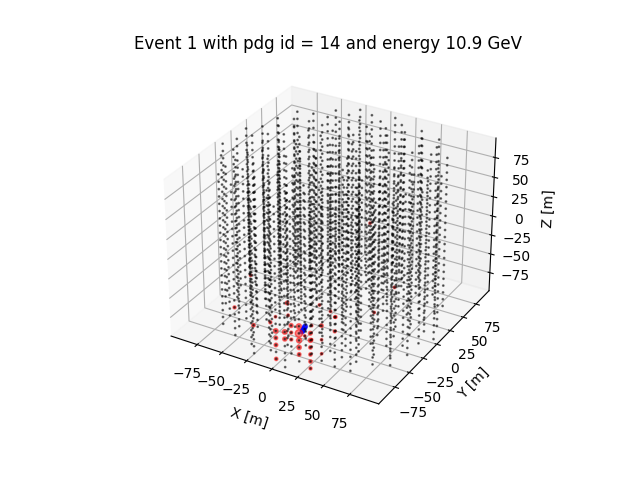

In [24]:
parquet_sub_plotting(
    example_set,
    e_id=1, det=det,
    channel='total',
    show_lepton=True,
    scaling=10,
    number_of_hits=1000,
    hitcut=0
)